In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 데이터 로드
train_df = pd.read_csv('/content/train_for_NLP.csv')
test_df = pd.read_csv('/content/test_cleaned.csv')

# train 데이터에서 특성과 레이블 분리
X_train = train_df['combined_str'].values
y_train = train_df['target'].values  # 이진 변수: 0과 1

# test 데이터의 특성
X_test = test_df['combined_str'].values

In [5]:
from transformers import TFDistilBertModel, DistilBertTokenizer

# DistilBERT 모델 및 토크나이저 로드
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [6]:
# 토큰화 및 입력 시퀀스 생성 함수
def tokenize_and_pad(texts, tokenizer, max_len=30):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # [CLS]와 [SEP] 토큰 추가
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = np.array(input_ids).squeeze()  # 차원 축소
    attention_masks = np.array(attention_masks).squeeze()

    return input_ids, attention_masks

# 학습 및 테스트 데이터 토큰화
max_len = 30  # 최대 시퀀스 길이
X_train_ids, X_train_masks = tokenize_and_pad(X_train, tokenizer, max_len)
X_test_ids, X_test_masks = tokenize_and_pad(X_test, tokenizer, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
# BERT 임베딩 생성 함수 수정
def create_bert_embeddings(input_ids, attention_masks, bert_model, batch_size=8):
    embeddings = []
    for i in range(0, len(input_ids), batch_size):
        input_ids_batch = input_ids[i:i+batch_size]
        attention_masks_batch = attention_masks[i:i+batch_size]
        bert_outputs = bert_model(input_ids_batch, attention_mask=attention_masks_batch)
        embeddings.append(bert_outputs.last_hidden_state)
    return tf.concat(embeddings, axis=0)

# 학습 및 테스트 데이터에 대한 BERT 임베딩 생성
X_train_embeddings = create_bert_embeddings(X_train_ids, X_train_masks, bert_model)
X_test_embeddings = create_bert_embeddings(X_test_ids, X_test_masks, bert_model)

In [21]:
# LSTM 모델 설계
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(max_len, 768)),  # BERT 임베딩 차원 768
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 시그모이드 출력층
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train_embeddings, y_train,
    validation_split=0.3,
    epochs=3,
    batch_size=16
    ,
    callbacks=[early_stopping]
)


Epoch 1/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6834 - loss: 0.5791 - val_accuracy: 0.8100 - val_loss: 0.4448
Epoch 2/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7984 - loss: 0.4455 - val_accuracy: 0.8095 - val_loss: 0.4428
Epoch 3/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8128 - loss: 0.4276 - val_accuracy: 0.8025 - val_loss: 0.4503


In [16]:
# 테스트 데이터에 대한 예측 수행
y_test_pred_prob = model.predict(X_test_embeddings)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

submission_df = pd.read_csv("/content/sample_submission.csv")
submission_df['target'] = y_test_pred

# 예측 결과를 DataFrame으로 저장
submission_df.to_csv('/content/BERT_LSTM_shortseq.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


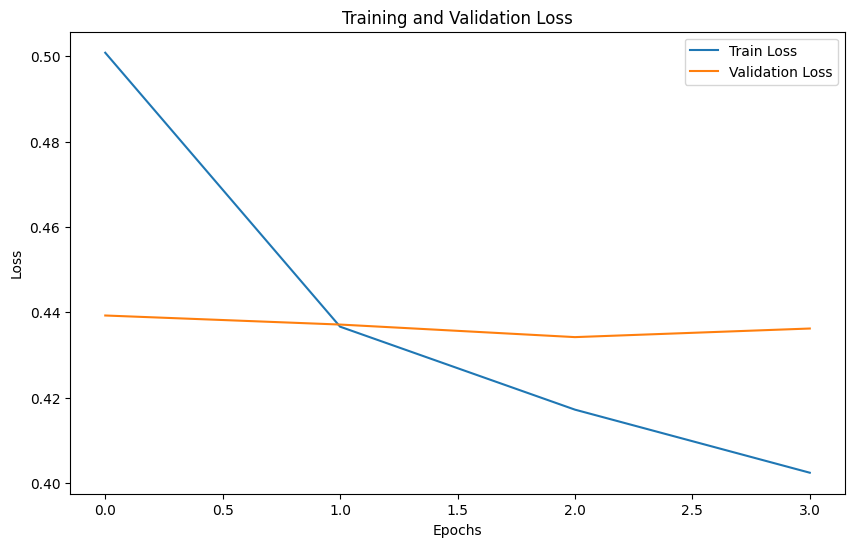

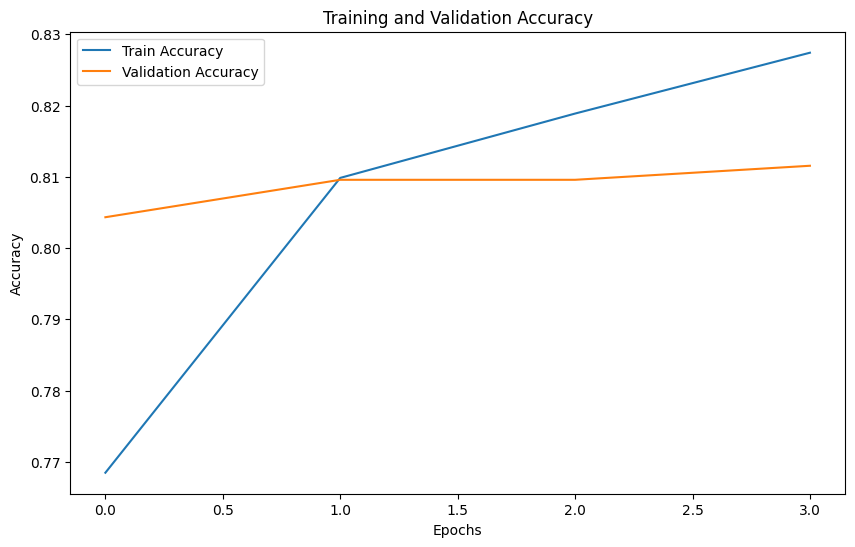

In [ ]:
import matplotlib.pyplot as plt

# 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()